In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from financepy.utils import *
from financepy.products.rates import *
from financepy.products.bonds import *

####################################################################
# FINANCEPY BETA Version 0.230 - This build:  30 Aug 2022 at 19:57 #
#      This software is distributed FREE & WITHOUT ANY WARRANTY    #
#  Report bugs as issues at https://github.com/domokane/FinancePy  #
####################################################################



# OIS data preparation

In [3]:
xls = pd.ExcelFile("Bloomberg - Historical Data v2.03.xlsx")
df = pd.read_excel(xls, sheet_name='gbp ois results')
df.head()

,Unnamed: 0,BPSWS1Z Curncy,Unnamed: 2,BPSWS2Z Curncy,Unnamed: 4,BPSWSA Curncy,Unnamed: 6,BPSWSB Curncy,Unnamed: 8,BPSWSE Curncy,...,Unnamed: 48,BPSWS20 Curncy,Unnamed: 50,BPSWS25 Curncy,Unnamed: 52,BPSWS30 Curncy,Unnamed: 54,BPSWS40 Curncy,Unnamed: 56,BPSWS50 Curncy
0,2022-01-27,0.19560,2022-01-27,0.38050,2022-01-27,0.38050,2022-01-27,0.4339,2022-01-27,0.61670,...,2022-01-27,1.0665,2022-01-27,1.02200,2022-01-27,0.9812,2022-01-27,0.89275,2022-01-27,0.80450
1,2022-01-28,0.22930,2022-01-28,0.38450,2022-01-28,0.38450,2022-01-28,0.4375,2022-01-28,0.63216,...,2022-01-28,1.0938,2022-01-28,1.05250,2022-01-28,1.0158,2022-01-28,0.92410,2022-01-28,0.83600
2,2022-01-31,0.33260,2022-01-31,0.41175,2022-01-31,0.41175,2022-01-31,0.4710,2022-01-31,0.66400,...,2022-01-31,1.1440,2022-01-31,1.10225,2022-01-31,1.0670,2022-01-31,0.98105,2022-01-31,0.89615
3,2022-02-01,0.36900,2022-02-01,0.42165,2022-02-01,0.42165,2022-02-01,0.4770,2022-02-01,0.66610,...,2022-02-01,1.1330,2022-02-01,1.09200,2022-02-01,1.0560,2022-02-01,0.96620,2022-02-01,0.88300
4,2022-02-02,0.40855,2022-02-02,0.43415,2022-02-02,0.43415,2022-02-02,0.4900,2022-02-02,0.67320,...,2022-02-02,1.0960,2022-02-02,1.05100,2022-02-02,1.0110,2022-02-02,0.92025,2022-02-02,0.83355


In [4]:
ticker = pd.read_excel(xls, sheet_name='Ticker')
ticker = pd.DataFrame(ticker, columns=['Term', 'Unit', 'Data Ticker'])
def convert_to_years(row):
    if row['Unit'] == 'WK':
        return row['Term'] / 52
    elif row['Unit'] == 'MO':
        return row['Term'] / 12
    else:
        return row['Term']
ticker['Years'] = ticker.apply(convert_to_years, axis=1)
ticker = pd.DataFrame(ticker, columns=['Years', 'Data Ticker'])
ticker.head()

,Years,Data Ticker
0,0.019231,BPSWS1Z Curncy
1,0.038462,BPSWS2Z Curncy
2,0.083333,BPSWSA Curncy
3,0.166667,BPSWSB Curncy
4,0.250000,BPSWSC Curncy


In [5]:
dates_columns = [col for col in df.columns if col.startswith('Unnamed')]
swaps_columns = [col for col in df.columns if col not in dates_columns]

# Find the common dates
common_dates = set(df[dates_columns[0]])

for column in dates_columns[1:]:
    common_dates = common_dates.intersection(set(df[column]))

In [6]:
# Iterate over the columns and split into separate DataFrames
dfs = []
for i in range(0, len(df.columns), 2):
    sub_df = df.iloc[:, i:i+2].copy()
    sub_df.columns = ['Date', df.columns[i+1]]
    dfs.append(sub_df)

# Filter each DataFrame based on common dates
filtered_dfs = []
for sub_df in dfs:
    filtered_df = sub_df[sub_df['Date'].isin(common_dates)]
    filtered_dfs.append(filtered_df)

In [7]:
merged_df = filtered_dfs[0]
for df in filtered_dfs[1:]:
    merged_df = pd.merge(merged_df, df, on='Date')

# Print the merged DataFrame
merged_df.head()

,Date,BPSWS1Z Curncy,BPSWS2Z Curncy,BPSWSA Curncy,BPSWSB Curncy,BPSWSE Curncy,BPSWSF Curncy,BPSWSG Curncy,BPSWSH Curncy,BPSWSI Curncy,...,BPSWS8 Curncy,BPSWS9 Curncy,BPSWS10 Curncy,BPSWS12 Curncy,BPSWS15 Curncy,BPSWS20 Curncy,BPSWS25 Curncy,BPSWS30 Curncy,BPSWS40 Curncy,BPSWS50 Curncy
0,2022-01-27,0.19560,0.38050,0.38050,0.4339,0.61670,0.6738,0.7420,0.79440,0.84270,...,1.18400,1.17000,1.15820,1.1314,1.1148,1.0665,1.02200,0.9812,0.89275,0.80450
1,2022-01-28,0.22930,0.38450,0.38450,0.4375,0.63216,0.6910,0.7589,0.81300,0.86277,...,1.20635,1.19205,1.18135,1.1593,1.1387,1.0938,1.05250,1.0158,0.92410,0.83600
2,2022-01-31,0.33260,0.41175,0.41175,0.4710,0.66400,0.7230,0.7967,0.85310,0.90340,...,1.25550,1.23790,1.22800,1.2130,1.1860,1.1440,1.10225,1.0670,0.98105,0.89615
3,2022-02-01,0.36900,0.42165,0.42165,0.4770,0.66610,0.7255,0.7940,0.85360,0.89930,...,1.24800,1.23400,1.22400,1.2038,1.1779,1.1330,1.09200,1.0560,0.96620,0.88300
4,2022-02-02,0.40855,0.43415,0.43415,0.4900,0.67320,0.7258,0.7908,0.84631,0.89184,...,1.22300,1.20800,1.19700,1.1750,1.1470,1.0960,1.05100,1.0110,0.92025,0.83355


# OIS curve

In [8]:
corresponding_years = []
for column_name in merged_df.columns:
    # Check if column name appears in 'Data Ticker' column of ticker dataframe
    ticker_row = ticker[ticker['Data Ticker'] == column_name]
    if not ticker_row.empty:
        # Extract corresponding 'Years' value
        years_value = ticker_row.iloc[0]['Years']
        corresponding_years.append(years_value)

In [9]:
depoDCCType = DayCountTypes.THIRTY_E_360_ISDA
depos = []
spot_days = 0

swapType = SwapTypes.PAY
fixedDCCType = DayCountTypes.ACT_365F
fixedFreqType = FrequencyTypes.ANNUAL

# ois swaps that is going to be used
# other consideration? other choices?
m2 = merged_df[['Date','BPSWSB Curncy']]
m6 = merged_df[['Date','BPSWSF Curncy']]
s1 = merged_df[['Date','BPSWS1 Curncy']]
s1f = merged_df[['Date','BPSWS1F Curncy']]
s2 = merged_df[['Date','BPSWS2 Curncy']]
s3 = merged_df[['Date','BPSWS3 Curncy']]
s4 = merged_df[['Date','BPSWS4 Curncy']]
s5 = merged_df[['Date','BPSWS5 Curncy']]
s7 = merged_df[['Date','BPSWS7 Curncy']]
s8 = merged_df[['Date','BPSWS8 Curncy']]
s9 = merged_df[['Date','BPSWS9 Curncy']]
s10 = merged_df[['Date','BPSWS10 Curncy']]

ois_curves = {}

# fit OIS curve for each day
for date in merged_df.Date:
    
    valuation_date = Date(date.day,date.month,date.year)
    settlement_date = valuation_date.add_weekdays(spot_days)
    
    swaps = []
    swap = OIS(settlement_date, "2M", swapType, m2[m2['Date']==date].iloc[0,1]/100., fixedFreqType, fixedDCCType); swaps.append(swap)
    swap = OIS(settlement_date, "6M", swapType, m6[m6['Date']==date].iloc[0,1]/100., fixedFreqType, fixedDCCType); swaps.append(swap)
    swap = OIS(settlement_date, "1Y", swapType, s1[s1['Date']==date].iloc[0,1]/100., fixedFreqType, fixedDCCType); swaps.append(swap)
    swap = OIS(settlement_date, "18M", swapType, s1f[s1f['Date']==date].iloc[0,1]/100., fixedFreqType, fixedDCCType); swaps.append(swap)
    swap = OIS(settlement_date, "2Y", swapType, s2[s2['Date']==date].iloc[0,1]/100., fixedFreqType, fixedDCCType); swaps.append(swap)
    swap = OIS(settlement_date, "3Y", swapType, s3[s3['Date']==date].iloc[0,1]/100., fixedFreqType, fixedDCCType); swaps.append(swap)
    swap = OIS(settlement_date, "4Y", swapType, s4[s4['Date']==date].iloc[0,1]/100., fixedFreqType, fixedDCCType); swaps.append(swap)
    swap = OIS(settlement_date, "5Y", swapType, s5[s5['Date']==date].iloc[0,1]/100., fixedFreqType, fixedDCCType); swaps.append(swap)
    swap = OIS(settlement_date, "7Y", swapType, s7[s7['Date']==date].iloc[0,1]/100., fixedFreqType, fixedDCCType); swaps.append(swap)
    swap = OIS(settlement_date, "8Y", swapType, s8[s8['Date']==date].iloc[0,1]/100., fixedFreqType, fixedDCCType); swaps.append(swap)
    swap = OIS(settlement_date, "9Y", swapType, s9[s9['Date']==date].iloc[0,1]/100., fixedFreqType, fixedDCCType); swaps.append(swap)
    swap = OIS(settlement_date, "10Y", swapType, s10[s10['Date']==date].iloc[0,1]/100., fixedFreqType, fixedDCCType); swaps.append(swap)
    
    oisCurveLZ = OISCurve(valuation_date, [], [], swaps, InterpTypes.LINEAR_ZERO_RATES)
    
    ois_curves.update({date:oisCurveLZ})

the valuation date is:  2022-06-23 00:00:00


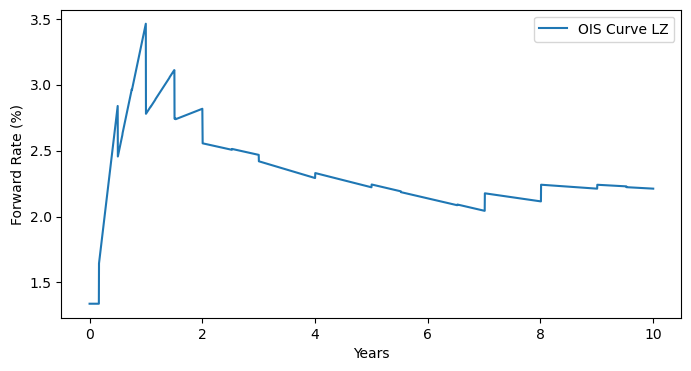

In [10]:
# plot a sample

date = merged_df.iloc[100,0]
print('the valuation date is: ',date)
valuation_date = Date(date.day,date.month,date.year)
settlement_date = valuation_date.add_weekdays(spot_days)

years = np.linspace(0, 10, 10*365)
dates = settlement_date.add_years(years)  
oisCurveFwds = ois_curves[date].fwd(dates)    

plt.figure(figsize=(8,4))
plt.plot(years, oisCurveFwds*100.0, label="OIS Curve LZ")
plt.xlabel("Years")
plt.ylabel("Forward Rate (%)")
plt.legend();

# Bond data preparation

In [11]:
b_info = pd.read_excel('bond2.0.xlsx', sheet_name='info')
b_info.head()

,Issuer Name,Ticker,Issue Date,Cpn,Maturity,BBG Composite,Mty Type,Currency,ID
0,United Kingdom Gilt,UKT,20/05/2020,0.500,22/10/2061,NR,AT MATURITY,GBP,BJ457937 Corp
1,United Kingdom Gilt,UKT,02/07/2021,0.250,31/01/2025,NR,AT MATURITY,GBP,BQ252040 Corp
2,United Kingdom Gilt,UKT,03/06/2020,0.125,30/01/2026,NR,AT MATURITY,GBP,BH295957 Corp
3,United Kingdom Gilt,UKT,02/09/2021,0.500,31/01/2029,NR,AT MATURITY,GBP,BR181418 Corp
4,United Kingdom Gilt,UKT,12/06/2020,0.125,31/01/2028,NR,AT MATURITY,GBP,BJ883026 Corp


In [12]:
b_dt = pd.read_excel('bond2.0.xlsx', sheet_name='result')
b_dt.head()

,Date,BJ457937 Corp,BQ252040 Corp,BH295957 Corp,BR181418 Corp,BJ883026 Corp,AZ278084 Corp,BJ787656 Corp,BM310773 Corp,EC453273 Corp,...,AS462336 Corp,EK333934 Corp,ZS535571 Corp,AM064544 Corp,EI825311 Corp,AU379648 Corp,EJ712548 Corp,QJ158195 Corp,EG872949 Corp,EC867711 Corp
0,2022-01-27,77.921,97.800,96.625,95.705,94.528,98.923,82.801,91.256,112.237,...,119.484,140.789,107.769,113.278,159.496,108.355,182.585,144.399,130.169,137.427
1,2022-01-28,77.496,97.786,96.614,95.634,94.496,98.907,82.401,91.134,112.187,...,118.884,140.325,107.252,112.776,158.853,107.911,181.781,143.732,129.987,137.132
2,2022-01-31,75.285,97.589,96.365,95.250,94.157,98.681,80.760,90.640,111.951,...,115.465,138.538,105.148,110.309,156.295,106.080,177.438,140.249,129.409,135.996
3,2022-02-01,75.828,97.563,96.348,95.252,94.137,98.650,81.197,90.665,111.915,...,116.282,138.993,105.642,110.874,156.953,106.532,178.462,141.082,129.433,136.224
4,2022-02-02,77.673,97.641,96.456,95.531,94.365,98.738,82.582,91.031,111.992,...,119.045,140.522,107.457,112.920,159.140,108.058,181.949,143.878,129.847,137.090


In [13]:
bond_data = b_dt[b_dt['Date'].isin(merged_df.Date.values)]
bond_data.tail()

,Date,BJ457937 Corp,BQ252040 Corp,BH295957 Corp,BR181418 Corp,BJ883026 Corp,AZ278084 Corp,BJ787656 Corp,BM310773 Corp,EC453273 Corp,...,AS462336 Corp,EK333934 Corp,ZS535571 Corp,AM064544 Corp,EI825311 Corp,AU379648 Corp,EJ712548 Corp,QJ158195 Corp,EG872949 Corp,EC867711 Corp
526,2024-02-12,29.468,95.831,92.332,84.521,85.955,95.050,39.999,76.161,100.202,...,45.993,85.693,52.118,52.925,87.041,58.457,81.903,63.400,104.830,100.189
527,2024-02-13,28.984,95.711,92.090,84.047,85.524,94.903,39.428,75.659,100.059,...,45.332,84.850,51.410,52.249,86.090,57.756,80.959,62.634,104.179,99.338
528,2024-02-14,29.591,95.827,92.325,84.543,85.965,95.062,40.074,76.221,100.195,...,46.100,85.735,52.177,53.007,87.127,58.519,82.066,63.531,104.873,100.270
529,2024-02-15,29.372,95.834,92.310,84.540,85.959,95.060,39.874,76.200,100.189,...,45.822,85.500,51.910,52.717,86.797,58.274,81.654,63.207,104.828,100.210
530,2024-02-16,28.966,95.816,92.234,84.298,85.745,95.017,39.461,75.914,100.127,...,45.287,84.926,51.394,52.204,86.128,57.778,80.873,62.579,104.447,99.684


# Fit NSS-model to z-spreads

To answer this question, we mainly follow the procedure of FinancePy/notebooks/products/bonds/FINBONDYIELDCURVE_FittingToAswAndZSpreads.ipynb
https://github.com/piterbarg/FinancePy/tree/5c9ba8427716e899eef6aa4fb1e66be75a088742/notebooks/products/bonds

## Z-spreads calculation

In [14]:
# SPECIFY UK BOND CONVENTIONS
frequencyType = FrequencyTypes.SEMI_ANNUAL

accrual_type = DayCountTypes.ACT_ACT_ICMA

In [15]:
cal = CalendarTypes.UNITED_KINGDOM

# initiate empty z-spreads dataframe
z_spreads = pd.DataFrame(columns=bond_data.columns)
z_spreads['Date'] = bond_data['Date']

# initiate empty dataframe to save fitted parameters and curve
betas = pd.DataFrame(columns=['Date','beta1','beta2','beta3','beta4'])
betas['Date'] = bond_data['Date']

# initiate empty disctionary to save fitted curves
fitted_curves = {}

In [16]:
# LOAD BONDS AND CREATE A VECTOR OF FINBOND AND THEIR CORRESPONDING z-spreads
# THEN FIT NSS MODEL

curveFitMethod = CurveFitNelsonSiegelSvensson()

i = 0
for date in z_spreads.Date:
    j = 1
    bonds = []
    settlement = Date(date.day, date.month,date.year)
    for bid in b_info.ID.values:
        # z-spread calculation
        date_string = b_info[b_info['ID']==bid].iat[0,4]
        matDatetime = pd.to_datetime(date_string,format='%d/%m/%Y')
        maturityDt = from_datetime(matDatetime)
        coupon = b_info[b_info['ID']==bid].iat[0,3]/100.0
        clean_price = bond_data[bid].iat[i]
        dd = b_info[b_info['ID']==bid].iat[0,2]
        dt = pd.to_datetime(dd,format='%d/%m/%Y')
        issue_date = Date(dt.day, dt.month, dt.year)
        bond = Bond(issue_date, maturityDt, coupon, frequencyType, accrual_type)
        
        z_spread = bond.z_spread(settlement, clean_price, ois_curves[date])
        bonds.append(bond)  
        # update z-spread data
        z_spreads.iloc[i,j] = z_spread
        j = j+1
    
    # fit NSS model
    fittedCurve4z = BondYieldCurve(settlement, bonds, z_spreads.iloc[i,1:].tolist(), curveFitMethod)
    # update fitted curve data
    fitted_curves.update({date:fittedCurve4z})
    betas.iloc[i,1] = fittedCurve4z._curveFit._beta1
    betas.iloc[i,2] = fittedCurve4z._curveFit._beta2
    betas.iloc[i,3] = fittedCurve4z._curveFit._beta3
    betas.iloc[i,4] = fittedCurve4z._curveFit._beta4
    i = i+1

valuation date:  2022-01-27 00:00:00


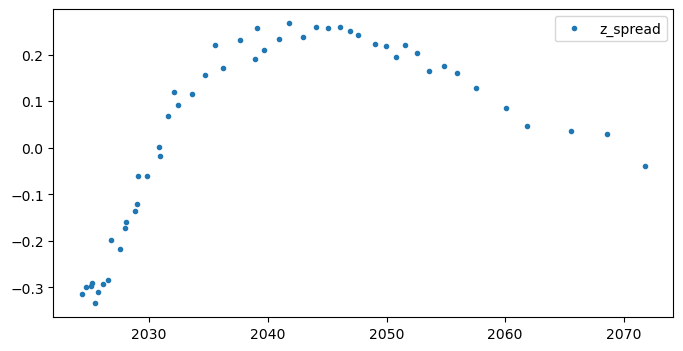

In [26]:

sample_date = bond_data.iloc[0,0]
print('valuation date: ',sample_date)
plt.figure(figsize=(8,4))
plt.plot(pd.to_datetime(b_info['Maturity'],format='%d/%m/%Y'), np.array(z_spreads.iloc[0,1:])*100, '.', label='z_spread')
plt.legend(loc='best')
plt.show()

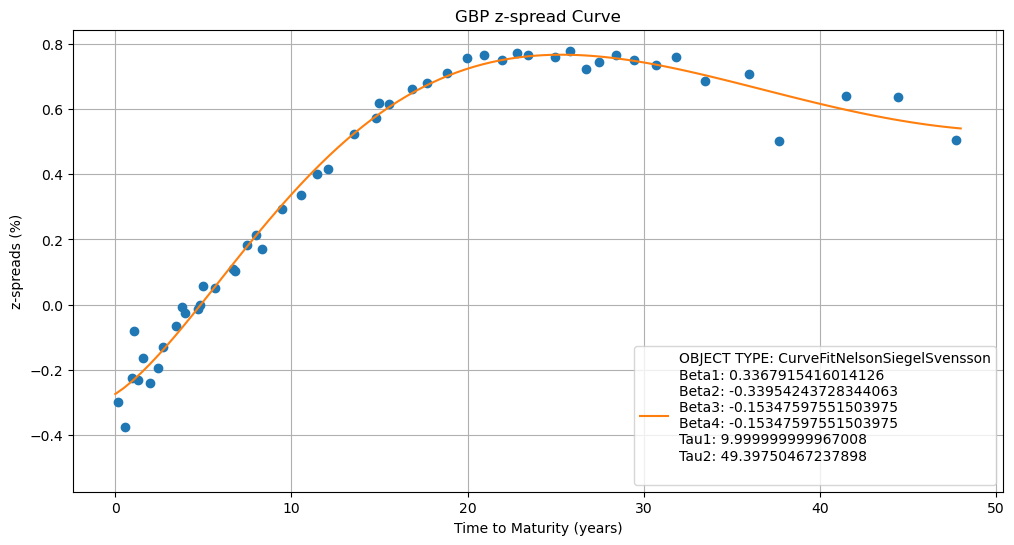

In [18]:
# plot NSS fitting sample
fittedCurve4z.plot("GBP z-spread Curve", ylabel = 'z-spreads (%)')

# Compute and analyse z-scores 

In [19]:
betas

,Date,beta1,beta2,beta3,beta4
0,2022-01-27,0.013308,-0.012278,-0.029764,-0.064519
1,2022-01-28,0.013394,-0.012474,-0.03044,-0.064819
2,2022-01-31,0.013806,-0.013406,-0.02976,-0.064562
3,2022-02-01,0.013182,-0.011894,-0.030323,-0.062491
4,2022-02-02,0.012592,-0.011403,-0.029418,-0.062265
...,...,...,...,...,...
526,2024-02-12,0.322263,-0.324771,-0.147339,-0.845956
527,2024-02-13,0.381646,-0.383691,-0.176352,-1.0
528,2024-02-14,0.335265,-0.33776,-0.152828,-0.879421
529,2024-02-15,0.311854,-0.314265,-0.143401,-0.819577


In [20]:
mu = betas.mean()
std = betas.std()
z_scores = (betas.iloc[:,1:] - mu) / std
z_scores['Date'] = bond_data['Date']
z_scores

,Date,beta1,beta2,beta3,beta4
0,2022-01-27,-0.849661,0.893709,0.867318,0.819631
1,2022-01-28,-0.848886,0.89196,0.851058,0.818589
2,2022-01-31,-0.845161,0.88367,0.867402,0.819482
3,2022-02-01,-0.850796,0.897122,0.853882,0.826663
4,2022-02-02,-0.856127,0.901485,0.875626,0.827443
...,...,...,...,...,...
526,2024-02-12,1.94061,-1.886005,-1.957393,-1.889598
527,2024-02-13,2.476913,-2.410116,-2.654435,-2.423663
528,2024-02-14,2.058039,-2.001549,-2.089265,-2.005619
529,2024-02-15,1.8466,-1.792556,-1.862797,-1.798143


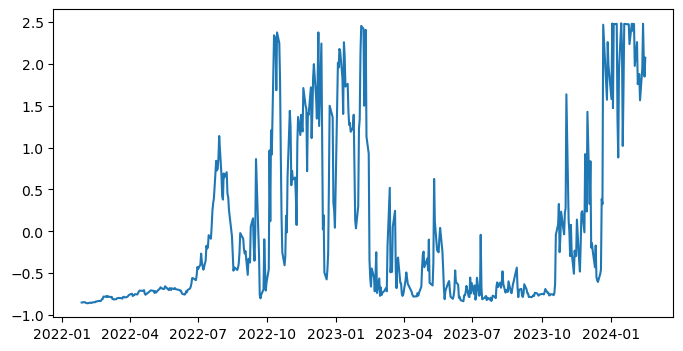

In [21]:
plt.figure(figsize=(8,4))
plt.plot(z_scores['Date'],z_scores['beta1'])
plt.show()

In [22]:
mm = np.min(z_scores.iloc[85:120,1])
z_scores[z_scores['beta1']==mm].iloc[0,0]

Timestamp('2022-06-13 00:00:00')

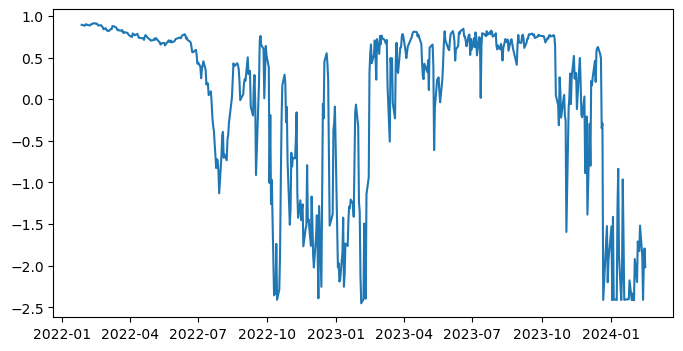

In [23]:
plt.figure(figsize=(8,4))
plt.plot(z_scores['Date'],z_scores['beta2'])
plt.show()

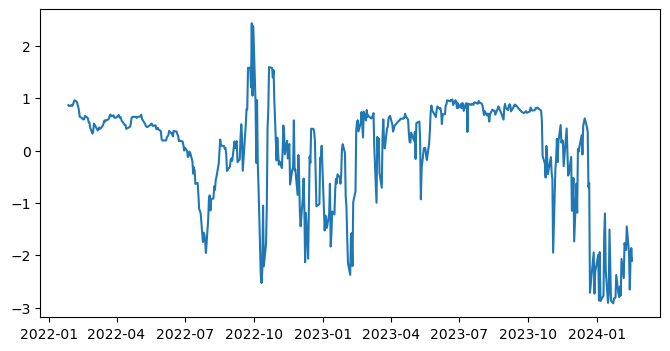

In [24]:
plt.figure(figsize=(8,4))
plt.plot(z_scores['Date'],z_scores['beta3'])
plt.show()

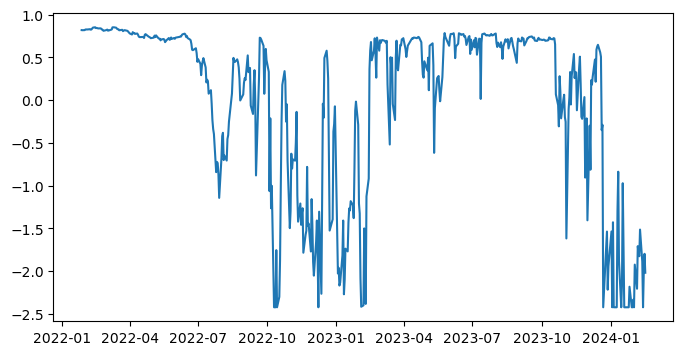

In [25]:
plt.figure(figsize=(8,4))
plt.plot(z_scores['Date'],z_scores['beta4'])
plt.show()